## Dependencias

In [77]:
import numpy as np
import pandas as pd

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score

from glob import glob 

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from varclushi import VarClusHi

from functools import reduce
from dateutil.relativedelta import relativedelta as rd

import warnings
import os 

warnings.filterwarnings('ignore')
cf.go_offline()

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Lectura de datos

In [13]:
ruta = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/02.  Para Ingeniería/aire/tad_parquet/*'
archivos = glob(ruta)

tad = pd.read_parquet(archivos)

In [14]:
tad.shape


(2444409, 148)

In [15]:
tad.head()

,fecha,hora,estacion,X_media_6_CO,X_media_12_CO,X_media_18_CO,X_media_24_CO,X_minimo_6_CO,X_minimo_12_CO,X_minimo_18_CO,...,X_minimo_24_SO2,X_maximo_6_SO2,X_maximo_12_SO2,X_maximo_18_SO2,X_maximo_24_SO2,X_desv_6_SO2,X_desv_12_SO2,X_desv_18_SO2,X_desv_24_SO2,target_o3_6
0,2011-10-15,2,ACO,0.47,0.36,0.36,0.43,0.40,0.20,0.20,...,0.00,2.00,2.00,3.00,3.00,0.52,0.67,0.76,0.72,10.00
1,2011-10-19,10,ACO,0.27,0.20,0.19,0.22,0.10,0.00,0.00,...,0.00,1.00,2.00,2.00,23.00,0.41,0.62,0.57,4.60,55.00
2,2011-08-22,21,ACO,0.82,0.72,0.75,0.71,0.70,0.60,0.60,...,1.00,2.00,2.00,2.00,2.00,0.52,0.45,0.46,0.44,20.00
3,2011-10-15,23,ACO,0.37,0.29,0.38,0.40,0.20,0.20,0.20,...,0.00,1.00,1.00,2.00,2.00,0.41,0.51,0.73,0.75,6.00
4,2011-10-13,2,ACO,0.42,0.49,0.51,0.55,0.20,0.20,0.20,...,0.00,2.00,3.00,3.00,3.00,0.82,0.79,0.85,0.87,1.00


In [16]:
vart = ['target_o3_6']

<Axes: >

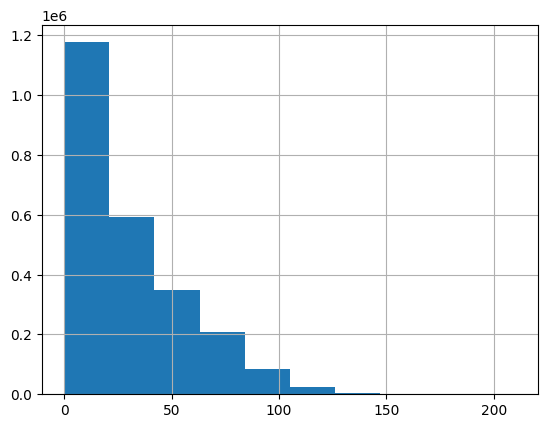

In [17]:
tad[vart[0]].hist()

In [18]:
tad = tad[~tad[vart[0]].isnull()].reset_index(drop=True)
tad.shape

(2444145, 148)

In [19]:
tad = tad[tad[vart[0]]>=0].reset_index(drop=True)
tad = tad[tad[vart[0]]<=108].reset_index(drop=True)

<Axes: >

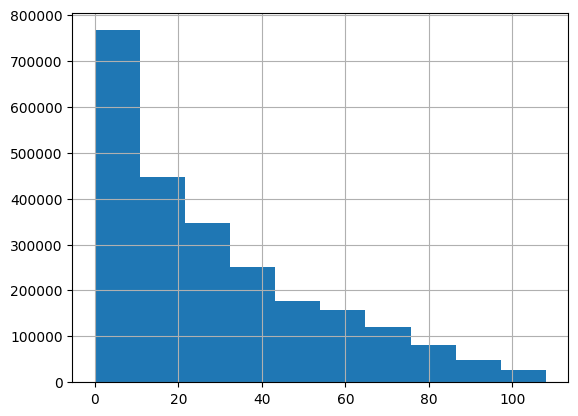

In [20]:
tad[vart[0]].hist()

### Partición

In [21]:
Sn, ot = [d.reset_index(drop=True) for _,d in tad.groupby(tad['fecha']>=pd.to_datetime('2020-12-01'))]
Sn.shape,ot.shape

((2372960, 148), (47372, 148))

In [22]:
train,valid = train_test_split(Sn,test_size=0.3,random_state=123)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((1661072, 148), (711888, 148))

In [24]:
train = train.sample(frac=0.05).reset_index(drop=True)

In [25]:
train.shape

(83054, 148)

## Análisis exploratorio de datos

In [26]:
um = ['fecha','hora','estacion']

In [27]:
varc = [v for v in train.columns if v.startswith('X_')]
len(varc)

144

### Ausentes

In [28]:
miss = (train[varc].isnull().sum()/len(train)).to_frame().rename(columns={0:'pct_miss'})
miss.sort_values(by='pct_miss',ascending=False,inplace=True)
fuera = miss[miss['pct_miss']>0.3].index.tolist()
train.drop(columns=fuera,inplace=True)
varc = [v for v in varc if v not in fuera]
len(varc)

96

In [29]:
im = SimpleImputer(strategy='median')
im.fit(train[varc])

SimpleImputer(strategy='median')

In [30]:
Xi = pd.DataFrame(im.transform(train[varc]),columns=varc)
Xi[um] = train[um]

In [31]:
ks = pd.DataFrame(map(lambda v: (v, stats.ks_2samp(Xi[v], train[v].dropna(
)).statistic), varc), columns=['var', 'ks']).sort_values(by='ks', ascending=False)
fuera = ks[ks['ks'] > 0.1]['var'].tolist()
Xi.drop(columns=fuera, inplace=True)
varc = [v for v in varc if v not in fuera]
len(varc)


60

### Multicolinealidad

In [33]:
vc = VarClusHi(df=Xi,feat_list=varc).varclus()

In [34]:
best = sorted(vc.rsquare.sort_values(by=['Cluster','RS_Ratio'],ascending=[1,1]).groupby('Cluster').first()['Variable'])
best

['X_desv_18_NO2',
 'X_desv_18_O3',
 'X_desv_18_SO2',
 'X_maximo_6_O3',
 'X_media_12_NO2',
 'X_media_12_O3',
 'X_media_6_SO2',
 'X_minimo_18_CO',
 'X_minimo_18_NO',
 'X_minimo_18_NO2',
 'X_minimo_18_SO2',
 'X_minimo_24_O3']

### Extremos

array([[<Axes: title={'center': 'X_desv_18_NO2'}>,
        <Axes: title={'center': 'X_desv_18_O3'}>,
        <Axes: title={'center': 'X_desv_18_SO2'}>],
       [<Axes: title={'center': 'X_maximo_6_O3'}>,
        <Axes: title={'center': 'X_media_12_NO2'}>,
        <Axes: title={'center': 'X_media_12_O3'}>],
       [<Axes: title={'center': 'X_media_6_SO2'}>,
        <Axes: title={'center': 'X_minimo_18_CO'}>,
        <Axes: title={'center': 'X_minimo_18_NO'}>],
       [<Axes: title={'center': 'X_minimo_18_NO2'}>,
        <Axes: title={'center': 'X_minimo_18_SO2'}>,
        <Axes: title={'center': 'X_minimo_24_O3'}>]], dtype=object)

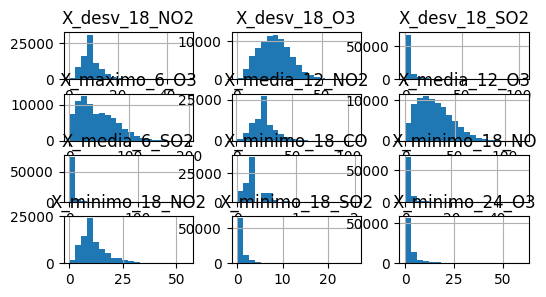

In [35]:
Xi[best].hist(figsize=(6,3),bins=20)

In [36]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi[f'ex_{v}'] = Xi[v].apply(lambda x: 1 if x<li or x>ls else 0)
Xi['ex_'] = Xi[[v for v in Xi.columns if v.startswith('ex_')]].max(axis=1)
Xi['ex_'].value_counts(1)


0   0.88
1   0.12
Name: ex_, dtype: float64

array([[<Axes: title={'center': 'X_desv_18_NO2'}>,
        <Axes: title={'center': 'X_desv_18_O3'}>,
        <Axes: title={'center': 'X_desv_18_SO2'}>],
       [<Axes: title={'center': 'X_maximo_6_O3'}>,
        <Axes: title={'center': 'X_media_12_NO2'}>,
        <Axes: title={'center': 'X_media_12_O3'}>],
       [<Axes: title={'center': 'X_media_6_SO2'}>,
        <Axes: title={'center': 'X_minimo_18_CO'}>,
        <Axes: title={'center': 'X_minimo_18_NO'}>],
       [<Axes: title={'center': 'X_minimo_18_NO2'}>,
        <Axes: title={'center': 'X_minimo_18_SO2'}>,
        <Axes: title={'center': 'X_minimo_24_O3'}>]], dtype=object)

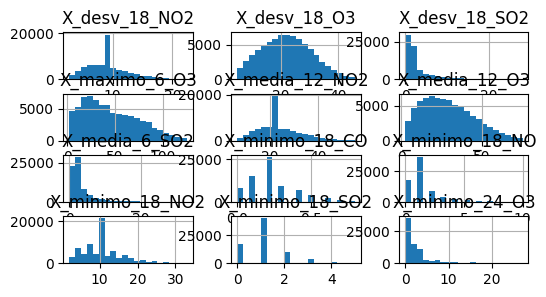

In [37]:
Xi[Xi['ex_']==0][best].hist(figsize=(6,3),bins=20)

In [38]:
Xi = Xi[Xi['ex_']==0].reset_index(drop=True)
Xi.drop([v for v in Xi.columns if v.startswith('ex_')],axis=1,inplace=True)

In [39]:
im.fit(train[best])

SimpleImputer(strategy='median')

In [40]:
aux = Xi[um+best].merge(train[um+vart],on=um,how='inner')
Xt,yt = aux[um+best].copy(),aux[um+vart].copy()

In [41]:
Xt.shape,yt.shape

((73416, 15), (73416, 4))

### Selección de variables

In [43]:
sc = MinMaxScaler()
sc.fit(Xt[best])
Xs = pd.DataFrame(sc.transform(Xt[best]),columns=best)
sk = SelectKBest(f_regression,k=len(best))
sk.fit(Xs,yt[vart[0]])
pd.Series(dict(zip(best,sk.scores_))).sort_values(ascending=False).iplot(kind='bar',color='purple')

In [44]:
sk = SelectKBest(f_regression, k=5)
sk.fit(Xs, yt[vart[0]])
best = pd.Series(dict(zip(best, sk.scores_))).sort_values(
    ascending=False).head(5).index.tolist()
best


['X_media_12_O3',
 'X_maximo_6_O3',
 'X_minimo_24_O3',
 'X_minimo_18_NO',
 'X_media_12_NO2']

## Espacios

In [45]:
scx = StandardScaler()
scy = StandardScaler()
scx.fit(Xt[best])
scy.fit(yt[vart])

StandardScaler()

In [47]:
Xs, ys = pd.DataFrame(scx.transform(Xt[best]), columns=best), pd.DataFrame(scy.transform(yt[vart]), columns=vart)

## Aprendizaje

In [78]:
reg = MLPRegressor()

In [79]:
hp = {'hidden_layer_sizes': [(a,b,c) for a in range(5,11) for b in range(2,11) for c in range(2,10)],
      'activation': ['identity', 'logistic', 'tanh', 'relu'],
      'solver': ['lbfgs', 'sgd', 'adam'],
      'alpha': [0.0001, 0.001, 0.01, 0.1],
      'learning_rate': ['constant', 'invscaling', 'adaptive'],
      'learning_rate_init': [0.001, 0.01, 0.1],
      'power_t': [0.1, 0.5, 1.0],
      'max_iter': [100, 200, 300],
      'shuffle': [True, False]}
reduce(lambda x,y: x*y,[len(hp[k]) for k in hp.keys()])

3359232

In [88]:
grid = RandomizedSearchCV(estimator=reg, 
                    param_distributions=hp, 
                    cv=5, 
                    scoring='neg_mean_squared_error', 
                    verbose=1, 
                    n_jobs=-1,
                    n_iter=20
                    )

grid.fit(Xs[best], ys[vart[0]])
# check top performing n_neighbors value
reg = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jose/entornos/amv/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/jose/entornos/amv/lib/python3.1

{'solver': 'lbfgs', 'shuffle': False, 'power_t': 0.1, 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (8, 2, 3), 'alpha': 0.001, 'activation': 'tanh'}
-0.6747288308917764


In [89]:
reg.fit(Xs[best],ys[vart[0]])

MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(8, 2, 3),
             learning_rate='adaptive', max_iter=300, power_t=0.1, shuffle=False,
             solver='lbfgs')

In [90]:
im.fit(train[best])

SimpleImputer(strategy='median')

## Generalización

In [91]:
pipe = make_pipeline(im,scx,reg)

In [92]:
train['y^'] = pd.DataFrame(scy.inverse_transform(pd.DataFrame(pipe.predict(train[best]),columns=vart)))[0]
valid['y^'] = pd.DataFrame(scy.inverse_transform(pd.DataFrame(pipe.predict(valid[best]),columns=vart)))[0]
ot['y^'] = pd.DataFrame(scy.inverse_transform(pd.DataFrame(pipe.predict(ot[best]),columns=vart)))[0]


In [93]:
{'train':np.abs(train[vart[0]]-train['y^']).mean(),
'valid':np.abs(valid[vart[0]]-valid['y^']).mean(),
'ot':np.abs(ot[vart[0]]-ot['y^']).mean()}


{'train': 15.897360648766037,
 'valid': 15.900188961779342,
 'ot': 14.405003027436608}

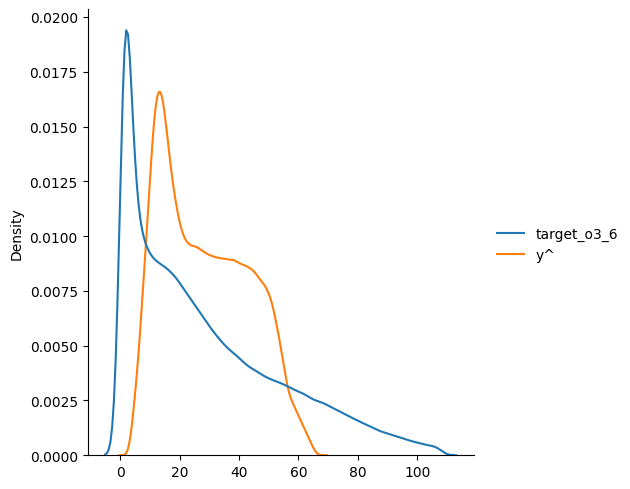

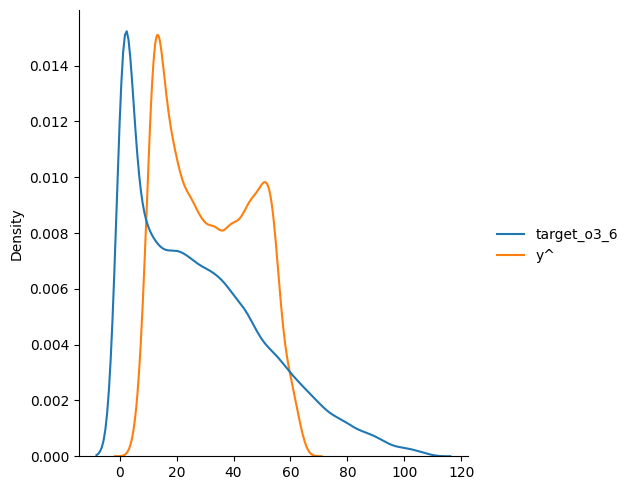

In [94]:
sns.displot(valid[vart+['y^']],kind='kde')
sns.displot(ot[vart+['y^']],kind='kde')

In [96]:
ot.sample(5)[['y^']+vart]

,y^,target_o3_6
15695,30.03,35.00
11102,17.56,8.00
34765,53.89,10.00
34379,15.99,34.00
33555,20.84,1.00
